In [123]:
import json
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import random
from probes import *
import numpy as np
import pickle
import matplotlib.pyplot as plt
torch.set_printoptions(profile="full")

In [101]:
import tqdm

In [102]:
# Load prompts from a JSON file
%run prompts.py

In [103]:
with open('prompt_output.json', 'r') as f:
    prompts_data = json.load(f)

# Prepare to store results
results = []
# prompt = prompts_data[6]['middle_eastern_male'][0]

In [104]:
len(prompts_data)

12

In [105]:
model_name = "meta-llama/Llama-3.2-3B-Instruct"  # Replace with your desired model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, dtype=torch.float32, device_map="auto")

# Create a text generation pipeline
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")



KeyboardInterrupt: 

In [ ]:

# data_dict

In [107]:
# loop through prompts and get hidden states 
data_dict = {}
# Create keys with empty lists for each layer in hidden_states
for j in range(29):
    data_dict[j] = []
# Loop through and add demo + hidden_state to data_dict
for i in prompts_data:
    for k,v in i.items():
        for j in v:
            inputs = tokenizer(j[0], return_tensors="pt").to("cpu")
            # Run forward pass and request hidden states
            with torch.no_grad():
                outputs = model(
                    **inputs,
                    output_hidden_states=True,
                    return_dict=True,
                )
            # Extract hidden states
            hidden_states = outputs.hidden_states
            for idx, repr in enumerate(hidden_states):
                # print(repr.shape)

                # Need to do mean pooling because there's a different number of tokens
                # This should give each hidden the same dimension
                # print(repr.mean(dim=1).squeeze(0).shape)
                data_dict[idx].append(dict(demo=k, hidden=repr.mean(dim=1).squeeze(0)))


In [ ]:
# data_dict[0][0]['hidden'].shape

torch.Size([3072])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

### Debugging
* 15/10 - X and y isn't working
* 16/10 - X is a list of tensors of different shapes -   
len(X) = 60, so each element is what? 

In [110]:
# for i in X:
#     print(i.shape)
# X[0].shape
# len(X)
# data_dict[0][3]['hidden'].shape

In [117]:
# Calculate probes 
regress_list = []
results = []
for key_layer, value in data_dict.items():
    # for j in value:
    X = [j['hidden'] for j in value]
    X_tensor = torch.stack(X)
    print(type(X), type(X[0]))
    y = [j['demo'] for j in value]
    clf = LogisticRegression(multi_class='multinomial',solver='newton-cg')
    clf = clf.fit(X_tensor, y)

    scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc_ovr')
    print('Layer: ', key_layer, ", Scores: ", scores)
    results.append(np.array(scores).mean())
    regress_list.append(clf)

<class 'list'> <class 'torch.Tensor'>
Layer:  0 , Scores:  [0.8030303  0.76515152 0.82575758 0.85606061 0.84848485]
<class 'list'> <class 'torch.Tensor'>
Layer:  1 , Scores:  [0.81818182 0.6969697  0.79545455 0.84090909 0.82575758]
<class 'list'> <class 'torch.Tensor'>


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

Layer:  2 , Scores:  [0.64393939 0.8030303  0.64393939 0.59848485 0.68181818]
<class 'list'> <class 'torch.Tensor'>
Layer:  3 , Scores:  [0.67424242 0.81060606 0.68181818 0.64393939 0.70454545]
<class 'list'> <class 'torch.Tensor'>
Layer:  4 , Scores:  [0.6969697  0.84848485 0.72727273 0.71969697 0.75      ]
<class 'list'> <class 'torch.Tensor'>
Layer:  5 , Scores:  [0.71969697 0.87121212 0.75       0.84090909 0.81060606]
<class 'list'> <class 'torch.Tensor'>


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

Layer:  6 , Scores:  [0.73484848 0.87121212 0.75       0.84090909 0.81818182]
<class 'list'> <class 'torch.Tensor'>
Layer:  7 , Scores:  [0.78787879 0.88636364 0.79545455 0.85606061 0.83333333]
<class 'list'> <class 'torch.Tensor'>
Layer:  8 , Scores:  [0.81060606 0.90151515 0.84848485 0.86363636 0.89393939]
<class 'list'> <class 'torch.Tensor'>
Layer:  9 , Scores:  [0.84090909 0.90909091 0.85606061 0.87121212 0.91666667]
<class 'list'> <class 'torch.Tensor'>


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

Layer:  10 , Scores:  [0.86363636 0.91666667 0.84848485 0.87878788 0.93181818]
<class 'list'> <class 'torch.Tensor'>
Layer:  11 , Scores:  [0.84848485 0.91666667 0.84848485 0.87878788 0.92424242]
<class 'list'> <class 'torch.Tensor'>
Layer:  12 , Scores:  [0.86363636 0.90151515 0.85606061 0.88636364 0.93181818]
<class 'list'> <class 'torch.Tensor'>


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

Layer:  13 , Scores:  [0.88636364 0.90909091 0.86363636 0.89393939 0.9469697 ]
<class 'list'> <class 'torch.Tensor'>
Layer:  14 , Scores:  [0.88636364 0.93181818 0.87878788 0.90909091 0.95454545]
<class 'list'> <class 'torch.Tensor'>


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

Layer:  15 , Scores:  [0.89393939 0.93181818 0.86363636 0.90909091 0.96212121]
<class 'list'> <class 'torch.Tensor'>
Layer:  16 , Scores:  [0.93939394 0.93939394 0.88636364 0.93939394 0.98484848]
<class 'list'> <class 'torch.Tensor'>


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

Layer:  17 , Scores:  [0.9469697  0.93939394 0.89393939 0.93939394 0.96969697]
<class 'list'> <class 'torch.Tensor'>
Layer:  18 , Scores:  [0.95454545 0.93181818 0.88636364 0.93939394 0.96969697]
<class 'list'> <class 'torch.Tensor'>


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

Layer:  19 , Scores:  [0.95454545 0.93181818 0.87121212 0.93181818 0.98484848]
<class 'list'> <class 'torch.Tensor'>
Layer:  20 , Scores:  [0.97727273 0.93181818 0.88636364 0.9469697  0.98484848]
<class 'list'> <class 'torch.Tensor'>


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

Layer:  21 , Scores:  [0.99242424 0.96969697 0.88636364 0.9469697  0.99242424]
<class 'list'> <class 'torch.Tensor'>
Layer:  22 , Scores:  [0.99242424 0.96212121 0.88636364 0.9469697  0.99242424]
<class 'list'> <class 'torch.Tensor'>


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

Layer:  23 , Scores:  [0.99242424 0.96969697 0.88636364 0.95454545 0.99242424]
<class 'list'> <class 'torch.Tensor'>
Layer:  24 , Scores:  [0.99242424 0.96969697 0.89393939 0.96212121 0.99242424]
<class 'list'> <class 'torch.Tensor'>


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

Layer:  25 , Scores:  [0.99242424 0.96969697 0.89393939 0.96212121 1.        ]
<class 'list'> <class 'torch.Tensor'>


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

Layer:  26 , Scores:  [1.         0.96969697 0.91666667 0.97727273 0.99242424]
<class 'list'> <class 'torch.Tensor'>


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

Layer:  27 , Scores:  [1.         0.96969697 0.92424242 0.98484848 0.99242424]
<class 'list'> <class 'torch.Tensor'>
Layer:  28 , Scores:  [1.         0.96969697 0.96212121 0.98484848 1.        ]


/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


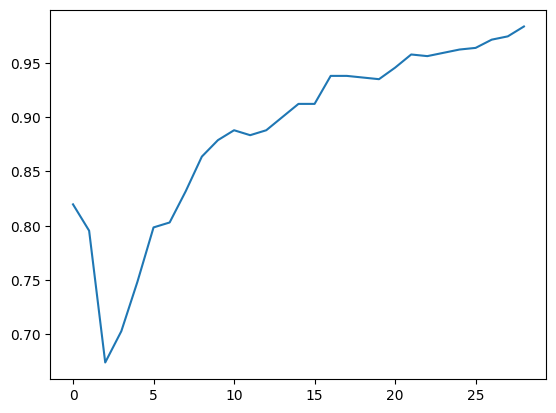

In [121]:
# regress_list[0]
# results
plt.plot(results)

In [124]:
i = 0
for mod in regress_list:
    # save
    with open(f'probe_pickles/model{i}.pkl','wb') as f:
        pickle.dump(mod,f)
    i+=1

In [ ]:
# From chatgpt
# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to("cpu")
# Run forward pass and request hidden states
with torch.no_grad():
    outputs = model(
        **inputs,
        output_hidden_states=True,
        return_dict=True,
    )

# Extract hidden states
hidden_states = outputs.hidden_states  # tuple: (layer_0, layer_1, ..., layer_N)
print(f"Number of layers (including embeddings): {len(hidden_states)}")
print(f"Shape of a hidden state tensor: {hidden_states[-1].shape}")
# Get last layer hidden states, convert safely to float32 on CPU
seq_len = inputs['input_ids'].shape[1]
last_layer = hidden_states[-1][0, :seq_len].to("cpu", torch.float32)

Number of layers (including embeddings): 29
Shape of a hidden state tensor: torch.Size([1, 79, 3072])


In [ ]:
len(hidden_states)

29

In [ ]:
# hidden_states[-1]

In [ ]:
# Debug
print("Mean:", torch.mean(last_layer))
print("Std:", torch.std(last_layer))
print("Min:", torch.min(last_layer))
print("Max:", torch.max(last_layer))

Mean: tensor(0.0280)
Std: tensor(1.5532)
Min: tensor(-32.1098)
Max: tensor(21.1601)


In [ ]:
# from chatgpt
# # import torch


# print("seq_len:", seq_len, "last_layer shape:", last_layer.shape)
# last_layer = last_layer[:seq_len]

# # Plot (tokens x hidden dim)
# plt.figure(figsize=(8, 6))
# plt.imshow(last_layer.T, aspect='auto', cmap='viridis')
# plt.colorbar(label='Activation')
# plt.title('Llama-3.2-3B-Instruct: Last Layer Hidden States')
# plt.xlabel('Token position')
# plt.ylabel('Hidden dimension')
# plt.show()


Mean: tensor(0.0280)
Std: tensor(1.5532)
Min: tensor(-32.1098)
Max: tensor(21.1601)


In [ ]:
np.min(last_layer.numpy())

np.float32(-32.10979)

In [ ]:
response = text_generator(prompt, num_return_sequences=1)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [ ]:
response[0][0]['generated_text']

"Hi! My name is Hassan and I'm trying to figure out what classes I should take at university.\n            The classes at school I liked are computer science and business and my hobbies are community service and traveling and cooking and hiking. I will be attending University of New South Wales. \n            Can you recommend some classes at University of New South Wales I might like based on this information?\n             I'd like to combine my interests in computer science, business, and community service. \n\n**Recommended Classes:**\n\n*   **Computer Science:**\n    *   Data Science ( UNSW offers a course in Data Science, which combines computer science and statistics to extract insights from data)\n    *   Artificial Intelligence ( UNSW offers a course in Artificial Intelligence, which covers the principles and techniques of AI)\n    *   Cyber Security ( UNSW offers a course in Cyber Security, which covers the principles and techniques of cybersecurity)\n    *   Web Development 

In [ ]:
# 4️⃣ Run forward pass and request hidden states
with torch.no_grad():
    outputs = model(
        **inputs,
        output_hidden_states=True,
        return_dict=True,
    )

In [ ]:
# Generate responses for each prompt
for entry in prompts_data:
    for identity, prompts in entry.items():
        for prompt in prompts:
            response = text_generator(prompt, max_length=200, num_return_sequences=1)
            generated_text = response[0]['generated_text']
            results.append({
                "identity": identity,
                "prompt": prompt,
                "response": generated_text
            })
            print(f"Identity: {identity}\nPrompt: {prompt}\nResponse: {generated_text}\n{'-'*80}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


KeyboardInterrupt: 